In [19]:
import pandas as pd
import numpy as np
# import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import shap
import seaborn as sns
import yaml

from scripts.check_overlaps import check_overlaps
from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf, long_range_interactions_results, create_vep_input, read_vcf, clean_and_preprocess

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

In [4]:
df = pd.read_csv('data/dataset_uncensored.csv')
df = repeat_masker(df, 'train')
df = COSMIC_CGC_interactions(df, 'train')
df = TF_binding_site_annotations(df, 'train')
df = long_range_interactions_results(df, 'train')
df

,chr,start,ref,alt,id,end,driver,data_source,DNA,LINE,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,1,1342375,A,G,mut943,1342375,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,5.461989,4.134149,5.763321,3.928504
1,1,2489274,G,A,mut245,2489274,1,ICGC,0,0,...,0,0,0.0,1.0,0.000000,0.934233,3.956033,3.028976,1.290733,0.910467
2,1,2492155,T,A,mut244,2492155,1,ICGC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,6.379211,4.819892,2.873550,1.947785
3,1,16477460,T,C,mut124,16477460,1,ICGC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,7.877773,5.922046,4.237756,2.917693
4,1,19114389,G,A,mut976,19114389,0,COSMIC,0,0,...,0,0,2.0,0.0,1.025076,0.000000,0.691125,0.482339,0.580283,0.338505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,X,142919453,A,G,mut866,142919453,0,COSMIC,0,1,...,0,0,0.0,0.0,0.000000,0.000000,0.124983,0.079273,0.000006,0.000006
1086,X,145999464,G,T,mut836,145999464,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,0.000158,0.000120,0.000013,0.000013
1087,X,148496412,G,T,mut661,148496412,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,0.000003,0.000003,0.000000,0.000000
1088,X,152710276,C,T,mut927,152710276,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,0.597337,0.383606,0.000019,0.000019


In [5]:
df_test = pd.read_csv('data/test_data_final.csv')
df_test = repeat_masker(df_test, 'test')
df_test = COSMIC_CGC_interactions(df_test, 'test')
df_test = TF_binding_site_annotations(df_test, 'test')
df_test = long_range_interactions_results(df_test, 'test')
df_test

,chr,start,ref,alt,end,region_type,reg_id,data_source,id,driver,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,1,2267093,C,T,2267093,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test30,1,...,0,0,1.0,0.0,6.012478,0.000000,0.0,0.0,0.0,0.0
1,1,2267139,G,A,2267139,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test3,1,...,0,0,1.0,0.0,1.587495,0.000000,0.0,0.0,0.0,0.0
2,1,2267211,C,T,2267211,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test29,1,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,1,2267473,C,T,2267473,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test36,1,...,0,0,2.0,0.0,1.041296,0.000000,0.0,0.0,0.0,0.0
4,1,2267569,G,A,2267569,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test37,1,...,0,0,0.0,2.0,0.000000,2.008131,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,9,125026995,C,G,125026996,Breast,MRRF,Dr.Nod 2023,test1116,1,...,0,0,1.0,0.0,1.443506,0.000000,0.0,0.0,0.0,0.0
1060,9,125027081,C,G,125027082,Breast,MRRF,Dr.Nod 2023,test1114,1,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1061,X,70338403,G,A,70338404,Brain,MED12,Dr.Nod 2023,test1118,1,...,0,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1062,X,70365659,G,A,70365660,Brain,MED12,Dr.Nod 2023,test1120,1,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [6]:
df_test.columns

Index(['chr', 'start', 'ref', 'alt', 'end', 'region_type', 'reg_id',
       'data_source', 'id', 'driver', 'DNA', 'LINE', 'LTR', 'SINE',
       'Simple_repeat', 'scRNA', 'tRNA', 'known_driver_gene',
       'known_driver_gene_100kb_downstream',
       'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
       'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream',
       'known_driver_gene_2kb_upstream', 'TF_loss', 'TF_gain', 'TF_loss_diff',
       'TF_gain_diff', 'CTCF_interactions', 'CTCF_chains',
       'POLR2A_interactions', 'POLR2A_chains'],
      dtype='object')

Creating the input file for VEP<br>
This file is then given to Ensembl VEP <br>
We used the web version: https://grch37.ensembl.org/Homo_sapiens/Tools/VEP/<br>
Make sure you are using the Grch37 version

In [31]:
df = create_vep_input(df, "data/VEP/vep_input.vcf")

In [36]:
test_df_vcf = create_vep_input(df_test, "data/VEP/vep_input_test.vcf")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Reading VEP output<br>
The file generated by Ensembl VEP is downloaded (in .txt format) and used

In [8]:
df_vep_output = read_vcf('data/VEP/vep_output.txt')
df_vep_output_test = read_vcf('data/VEP/vep_output_test.txt')

Clean and preprocess the data

In [9]:
df_vep_output = clean_and_preprocess(df_vep_output)
df_vep_output_test = clean_and_preprocess(df_vep_output_test)

In [11]:
data = df_vep_output.merge(df, left_on=['#Uploaded_variation', 'chr', 'start', 'end'], right_on=['id', 'chr', 'start', 'end'], how='right')
data_test = df_vep_output_test.merge(df_test, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test

,Allele,SYMBOL,STRAND,ENSP,UNIPARC,LOEUF,ada_score,rf_score,CADD_PHRED,CADD_RAW,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,T,MORN1,0.0,1.0,1.0,1.116,0.000000,0.00,0.859,-0.173168,...,0,0,1.0,0.0,6.012478,0.000000,0.0,0.0,0.0,0.0
1,A,MORN1,0.0,1.0,1.0,1.116,0.000000,0.00,0.546,-0.240995,...,0,0,1.0,0.0,1.587495,0.000000,0.0,0.0,0.0,0.0
2,T,MORN1,0.0,1.0,1.0,1.116,0.000000,0.00,0.096,-0.489119,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,T,MORN1,0.0,1.0,1.0,1.116,0.000000,0.00,3.532,0.056476,...,0,0,2.0,0.0,1.041296,0.000000,0.0,0.0,0.0,0.0
4,A,MORN1,0.0,1.0,1.0,1.116,0.000000,0.00,1.215,-0.121866,...,0,0,0.0,2.0,0.000000,2.008131,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,G,MRRF,1.0,9.0,8.0,1.409,0.474159,0.64,0.000,0.000000,...,0,0,1.0,0.0,1.443506,0.000000,0.0,0.0,0.0,0.0
1058,G,MRRF,1.0,9.0,8.0,1.409,0.000000,0.00,0.000,0.000000,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1059,A,MED12,1.0,4.0,4.0,0.000,0.000000,0.00,17.090,1.639441,...,0,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1060,A,MED12,1.0,7.0,7.0,0.241,0.000000,0.00,0.000,0.000000,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [15]:
# data.to_csv('data/final_dataset.csv', index = False)
data_test.to_csv('data/final_dataset_test.csv', index = False)

# XGBoost

In [ ]:
# data = pd.read_csv('data/final_dataset.csv')
data
# df = data[data['driver'] == 1]
# negdf = data[data['driver'] == 0]

In [37]:
# data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

# data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
# data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
# data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
# data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

# data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
# data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
# data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
# data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

data_test['TF_binding_site_agg'] = np.logical_or(data_test['TF_binding_site'], data_test['TF_binding_site_variant']).astype(int)

data_test['TF_loss_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss']
data_test['TF_gain_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain']
data_test['TF_loss_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss_diff']
data_test['TF_gain_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain_diff']

data_test['SpliceAI_pred_DP_AG'] = abs(data_test['SpliceAI_pred_DP_AG'])
data_test['SpliceAI_pred_DP_AL'] = abs(data_test['SpliceAI_pred_DP_AL'])
data_test['SpliceAI_pred_DP_DG'] = abs(data_test['SpliceAI_pred_DP_DG'])
data_test['SpliceAI_pred_DP_DL'] = abs(data_test['SpliceAI_pred_DP_DL'])

In [48]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 0.7,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 0,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 1,
        "learning_rate": 1e-03,
        "colsample_bylevel": 1.0,
        "gamma": 0,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

# 'ada_score', 'rf_score', 'CADD_PHRED', 'CADD_RAW', 'MODERATE', 'LOW', 'SWISSPROT', 'TREMBL', 'miRNA', 'sense_overlapping', 'misc_RNA'
# 'IG_D_gene', 'IG_J_gene', 'IG_C_gene', 'transcribed_unprocessed_pseudogene', 'non_stop_decay', '3prime_overlapping_ncRNA', 'pseudogene', 'transcribed_processed_pseudogene', 'rNA'
# 'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'start_lost', 'inframe_deletion', 'frameshift_variant' # not in positive set
# 'splice_acceptor_variant', 'coding_sequence_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant' # not in negative set
# open_chromatin_region, 'snRNA', 'snoRNA' # not enough values
# 'STRAND', 'TF_binding_site_variant', 'TF_binding_site', 

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

for col in list(set(COLUMNS_TRAINING) - set(data_test.columns)):
    data_test[col] = 0

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])
data_test[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data_test[COLUMNS_TRAINING])

valset = data[-5:]
data = data[:-5]
valset['driver']

Boxplot

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(30, 60))

bplot1 = ax1.boxplot(data[COLUMNS_TRAINING].iloc[:, 0:10],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[0:10])

bplot2 = ax2.boxplot(data[COLUMNS_TRAINING].iloc[:, 10:20],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[10:20])

bplot3 = ax3.boxplot(data[COLUMNS_TRAINING].iloc[:, 20:30],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[20:30])

bplot4 = ax4.boxplot(data[COLUMNS_TRAINING].iloc[:, 30:40],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[30:40])

bplot5 = ax5.boxplot(data[COLUMNS_TRAINING].iloc[:, 40:50],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[40:50])

bplot6 = ax6.boxplot(data[COLUMNS_TRAINING].iloc[:, 50:len(COLUMNS_TRAINING)],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[50:])

# adding horizontal grid lines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Normalized Observed values', fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)

fig.suptitle('Boxplot Normalised Dataset', fontsize=30)
fig.tight_layout(pad=2)
plt.show()

Histogram

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]
num = 8
col = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
for i in range(0, num):
    for j in range(0, num):
        colour_dict = {0: 'pink', 1: 'lightblue'}
        axes[i][j].hist([data.loc[data['driver'] == x, COLUMNS_TRAINING[col]] for x in colour_dict.keys()],
                color=[colour_dict[x] for x in colour_dict.keys()],
                edgecolor='black',
                stacked=True)
        axes[i][j].set_xlabel(COLUMNS_TRAINING_LABELS[col], fontsize=20, wrap=True)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].tick_params(axis='x', labelsize=15)

        col = col + 1
        if col >= len(COLUMNS_TRAINING):
            break

fig.suptitle('Histogram of Normalised Dataset', fontsize=30)
fig.legend(colour_dict, labels=['non-driver', 'driver'], loc='upper left', ncol = 2, fontsize=20)
fig.tight_layout(pad=2)

Correlation Matrix

In [ ]:
COLUMNS_WITH_DRIVER = COLUMNS_TRAINING
COLUMNS_WITH_DRIVER.append('driver')
corr_matrix = data[COLUMNS_TRAINING].corr()
matrix = np.triu(corr_matrix)
sns.set(font_scale=0.6)
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(30,30)})
# sns.set(rc=)

ax= sns.heatmap(corr_matrix, mask=matrix, vmin=-1, vmax=+1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7}, cmap='coolwarm')

sns.set()
for t in ax.texts:
    if float(t.get_text())>=0.4 or float(t.get_text())<=-0.4:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

# Sweep using WANDB

In [ ]:
from sklearn import metrics
from scipy.stats import ks_2samp
import wandb
from wandb.xgboost import WandbCallback
import os
os.environ["WANDB_API_KEY"] = config['WANDB_API_KEY']

xgboost.set_config(verbosity=0)

In [ ]:
sweep_config = {
  "method" : "grid",
  "parameters" : {
    "learning_rate" :{
      "values": [0.001, 0.005, 0.01]
    },
    "early_stopping_rounds" :{
      "values" : [1000, 2000, 4000]
    },
    "subsample": {    # fraction of observations to be random samples for each tree
      "values": [0.5, 0.7, 0.8, 1.0]
    },
    "max_depth": {
      "values": [4, 6]  
    }, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
  }
}

sweep_id = wandb.sweep(sweep_config, project='thesis', entity='sanabasharat')

def train():
  with wandb.init(job_type="sweep") as run:
    # for i in list_cvs: # for each of the 50 splits
    x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                        random_state=104, 
                                                        test_size=0.25, 
                                                        shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2
    
    bst_params = {
        'objective': 'binary:logistic'
        , 'base_score': y_train.mean()
        , 'gamma': 0
        , 'learning_rate': run.config['learning_rate']
        , 'max_depth': 3
        , 'n_estimators': 20000
        , 'random_state': 42
        , 'early_stopping_rounds': run.config['early_stopping_rounds']
        , 'eval_metric': 'logloss'
        , 'subsample': run.config['subsample']
        , 'max_depth': run.config['max_depth']
        , 'reg_lambda': 1
        , 'random_state': 42
        , 'scale_pos_weight': 1
        , 'silent': 1
        , 'seed': 21
        , 'reg_alpha': 0         # L1 regularization term on weight
        , 'max_delta_step': 0    # positive value can help make the update step more conservative. generally not used
        , 'min_child_weight': 1
        , 'colsample_bylevel': 1.0
        , 'colsample_bytree': 1.0        # fraction of columns to be random samples for each tree
        , 'booster': 'gbtree'
        , 'n_jobs' : 1
        , 'min_child_weight': 1
    }
    # params = XGB_PARAMS.copy()                                          
    # params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
    # params['base_score'] = y_train.mean()
    # params['n_jobs'] = 1
    # params['seed'] = seed
    model = XGBClassifier(**bst_params)

    # train with xgboost
    # learning_curve_dict = {}
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                        callbacks = [
                            xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False),
                            WandbCallback()
                        ],
                        verbose = 0)

    bst_params['n_estimators'] = model.best_iteration
    model.set_params(**bst_params)
    
    bstr = model.get_booster()

    # Log booster metrics
    run.summary["best_ntree_limit"] = bstr.best_ntree_limit
    
    # Get train and validation predictions
    trnYpreds = model.predict_proba(x_train)[:,1]
    valYpreds = model.predict_proba(x_val)[:,1] 

    # Log additional Train metrics
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, trnYpreds) 
    run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
    run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
    run.summary['train_log_loss'] = -(y_train * np.log(trnYpreds) + (1-y_train) * np.log(1-trnYpreds)).sum() / len(y_train)

    # Log additional Validation metrics
    ks_stat, ks_pval = ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0])
    run.summary["val_ks_2samp"] = ks_stat
    run.summary["val_ks_pval"] = ks_pval
    run.summary["val_auc"] = metrics.roc_auc_score(y_val, valYpreds)
    run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(valYpreds >= 0.5, 1, 0))
    run.summary["val_log_loss"] = -(y_val * np.log(valYpreds) + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)

In [ ]:
# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train)

# Simple run

In [64]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2

params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 1)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

In [60]:
y_test_data = data_test[COLUMNS_TRAINING]
y_test_data

,ada_score,rf_score,ENSP,UNIPARC,GO,LOEUF,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,...,synonymous_variant,stop_gained,stop_lost,splice_region_variant,inframe_insertion,frameshift_variant,TF_loss_add,TF_gain_add,TF_loss_diff_add,TF_gain_diff_add
0,0.0,0.0,0.000000,0.00,0.000000,0.566210,0.00,0.72,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.882018,0.000000
1,0.0,0.0,0.000000,0.00,0.000000,0.566210,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.232882,0.000000
2,0.0,0.0,0.000000,0.00,0.000000,0.566210,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.00,0.000000,0.566210,0.74,0.06,0.08,0.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.000000,0.152756,0.000000
4,0.0,0.0,0.000000,0.00,0.000000,0.566210,0.66,0.00,0.48,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.285714,0.000000,0.259733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,1.0,1.0,0.347826,0.35,0.051020,0.714866,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.250,0.142857,0.358457,0.129341
1058,0.0,0.0,0.347826,0.35,0.051020,0.714866,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.142857,0.146698,0.129341
1059,0.0,0.0,0.130435,0.15,0.357143,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000
1060,0.0,0.0,0.260870,0.30,0.765306,0.122273,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000


In [67]:
data_test['driver']

0       1
1       1
2       1
3       1
4       1
       ..
1057    1
1058    1
1059    1
1060    1
1061    1
Name: driver, Length: 1062, dtype: int64

In [66]:
y_pred_data = model.predict(y_test_data)
y_pred_data

array([0, 0, 0, ..., 1, 1, 0])

In [68]:
y_pred_data

array([0, 0, 0, ..., 1, 1, 0])

In [63]:
score = accuracy_score(data_test['driver'], y_pred_data)
print('Accuracy: %.3f' % score)

Accuracy: 0.351


In [69]:
log_loss(y_pred_data, data_test['driver'])

23.384253469963948

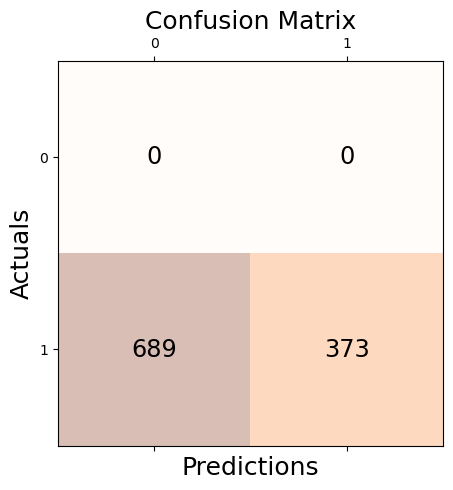

In [70]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=data_test['driver'], y_pred=y_pred_data)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

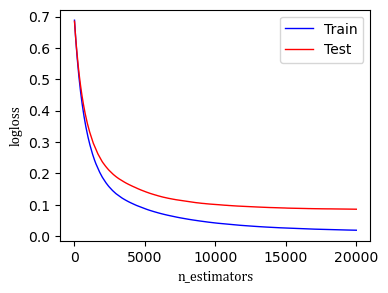

In [24]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [25]:
yhat = model.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

[22:17:17] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.967


In [26]:
log_loss(yhat, y_test)

1.1970216992695735

In [27]:
from random import seed
from random import randrange
 
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
 output_values = [row[-1] for row in train]
 prediction = max(set(output_values), key=output_values.count)
 predicted = [prediction for i in range(len(test))]
 return predicted

train = x_train
train['driver'] = y_train
test = x_test
test['driver'] = y_test
seed(1)
# train = [['0'], ['0'], ['0'], ['0'], ['1'], ['1']]
# test = [[None], [None], [None], [None]]
predictions = zero_rule_algorithm_classification(train, test)
print(predictions)

['t', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't',

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
print('precision: ', precision_score(y_test, yhat))
print('recall: ' , recall_score(y_test, yhat))
print('f1_score: ', f1_score(y_test, yhat))
print('roc_auc_score: ', roc_auc_score(y_test, yhat))

precision:  0.9658119658119658
recall:  0.9576271186440678
f1_score:  0.9617021276595744
roc_auc_score:  0.9657416638971974


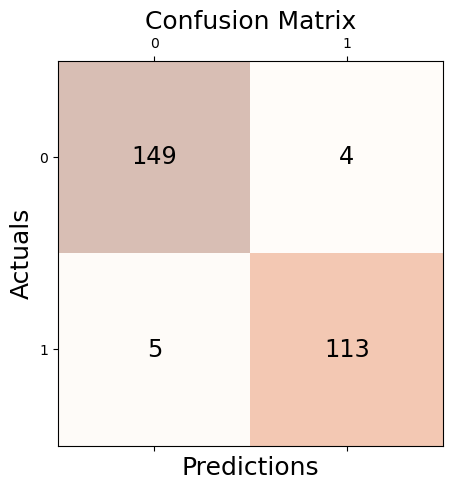

In [29]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=yhat)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [30]:
valsetpred = model.predict(valset[COLUMNS_TRAINING])
print(valset['driver'])
print(valsetpred)

1081    0
1082    0
1083    0
1084    0
1085    0
Name: driver, dtype: int64
[0 0 0 0 1]


SHAP Explainer

In [ ]:
# SHAP attribution
x_data = data[COLUMNS_TRAINING]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
# shap_values = np.mean(shap_bootstrap, axis=0)


In [ ]:
import joblib
filename = 'trained_model.sav'
joblib.dump(model, filename)
# model.to_pickle('trained_model.')
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(x_test, y_test)
print(result)

In [32]:
loaded_model

XGBClassifier(base_score=0.45555555555555555, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=2000,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=19986, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [ ]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [ ]:
x_data.columns

In [ ]:
x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
# x_data.columns.get_loc('splice_acceptor_variant')
# x_data.columns.get_loc('splice_donor_variant')
# x_data.columns.get_loc('LOEUF')
data['driver'].value_counts()

In [ ]:
shap_values[:,[60, 24, 38, 17, 23]]

In [ ]:
# shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,6:14], x_data.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
shap.summary_plot(shap_values[:,44:48], x_data.iloc[:, 44:48], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,53:60], x_data.iloc[:, 53:60], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,48:53], x_data.iloc[:, 48:53], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,73:77], x_data.iloc[:, 73:77], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,5:6], x_data.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values[:,[60, 24, 38, 17, 23]], x_data.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

In [ ]:
shap.summary_plot(shap_values, x_data, max_display=40)

In [ ]:
shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")

In [ ]:
# shap.plots.heatmap(shap_values)
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=12)

In [ ]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')

In [ ]:
import pandas as pd
import numpy as np
import os
from anytree import Node, RenderTree, AsciiStyle, LevelGroupOrderIter, LevelOrderGroupIter, search
from intervaltree import Interval, IntervalTree
import multiprocessing
import time

def read_dataset():
    df_pos = pd.read_csv('artifacts/df_grch38.bed', sep='\t', header=None)
    df_pos.columns = ['chr', 'start', 'end']

    orig = pd.read_csv('ICGC_TCGA_noncoding_data.csv')
    df_pos['pos_37'] = orig['pos']
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = pd.read_csv('negdf_grch38.bed', sep='\t', header=None)
    df_neg.columns = ['chr', 'start', 'end', 'old_pos', 'bed_format']
    df_neg['chr'] = df_neg['chr'].apply(lambda x: x.replace('chr', ''))
    df_neg['chr_old'] = df_neg['old_pos'].str.split(':').str[0].str.replace('chr', '')
    df_neg['start_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[1]
    df_neg['end_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[0]
    df_neg['start_old'] = pd.to_numeric(df_neg['start_old'])
    df_neg['end_old'] = pd.to_numeric(df_neg['end_old'])
    metadata = pd.read_csv(r'C:\Users\Sana\Downloads\ChiaPET\metadata.tsv', sep='\t')

    df_pos = df_pos[['chr', 'start', 'end', 'pos_37']]
    df_pos['driver'] = 1
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = df_neg[['chr', 'start', 'end', 'start_old']]
    df_neg['driver'] = 0
    df_neg.rename(columns = {'start_old': 'pos_37'}, inplace = True)
    df_neg.drop_duplicates(keep='first', inplace=True)

    df = pd.concat([df_pos, df_neg])
    return df                              # final dataset including negative and positive set

In [ ]:
df = read_dataset()
df.sort_values('chr', inplace=True)
df.reset_index(drop = True, inplace = True)
df['CTCF_interactions'] = 0
df['CTCF_chains'] = 0
df['POLR2A_interactions'] = 0
df['POLR2A_chains'] = 0

chr = '17'
mutation = 50862973
all_files = ['ENCFF271VMZ.bedpe']
for file in all_files:
    print(file)
    cp = pd.read_csv('C:/Users/Sana/Downloads/ChiaPET/' + file, sep = '\t',  header = None)
    cp.columns = ['chr_A', 'start_A', 'end_A', 'chr_B', 'start_B', 'end_B', 'score']
    cp['chr_A'] = cp['chr_A'].map(lambda x: x.replace('chr', ''))
    cp['chr_B'] = cp['chr_B'].map(lambda x: x.replace('chr', ''))
    
    cp = cp[cp['chr_A'] == chr]
    interactions_tree = IntervalTree()

    for index, row in cp.iterrows():
        interactions_tree.add(Interval(row['start_A'], row['end_A'], tuple([row['chr_A'], row['start_B'], row['end_B']]))) # fotwards interaction
        interactions_tree.add(Interval(row['start_B'], row['end_B'], tuple([row['chr_A'], row['start_A'], row['end_A']]))) # backwards interaction
        
    # df_tree = []
    
    # save_tree = interactions_tree.copy()
    # for index, row in df.iterrows():          # this is to make an AnyTree for each mutation in the dataset, and store them all in a list
    #     df_tree.append(Node(name = row['chr'] + ':' + str(row['start']) + '-' + str(row['end']), chr = row['chr'], start = row['start'], end = row['end'], checked = 0))

    # #checking just one mutation
    # df_tree = Node(name = 'artificial', chr = '17', start = 59210051, end = 59210052, checked = 0)
    df_tree = Node(name = 'artificial', checked = 0)
    # df_tree = Node(name = 'artificial', chr = '3', start = 5, end = 6, checked = 0)     # checking just one artificial mutation

    found_overlap = False
    if len(interactions_tree.at(mutation)) > 0:
        found_overlap = True
        for i in interactions_tree.at(mutation):
            Node(Interval(i.data[1], i.data[2]), checked = 0, parent = df_tree)
            interactions_tree.remove(i)
            inv = Interval(i.data[1], i.data[2], tuple([i.data[0], i.begin, i.end]))
            interactions_tree.remove(inv)

    interactions = 0
    chains = 0
    if found_overlap:
        children_left = True
        while children_left is True:
            children_left = False
            for node in df_tree.leaves:
                if node.checked == 0:
                    node.checked = 1
                    found_list = list(interactions_tree.overlap(node.name))
                    for found_node in found_list:
                        print("FOUND: ", found_node)
                        children_left = True
                        Node(name = Interval(found_node.data[1], found_node.data[2]), checked = 0, parent = node)
                        print("REMOVING: ", found_node)
                        try:
                            interactions_tree.remove(found_node)# only remove that node which satisfies both conditions of similarity
                        except:
                            pass
                        try:
                            interactions_tree.remove(Interval(found_node.data[1], found_node.data[2], tuple([found_node.data[0], found_node.begin, found_node.end])))
                        except:
                            pass

        interactions = len(set([k.name for k in df_tree.descendants]))
        chains = sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf])


    # if metadata[metadata['File accession'] == file.replace('.bedpe', '')]['Experiment target'].iloc[0].replace('-human', '') == 'CTCF':
    #     print('CTCF_interactions', len(df_tree.descendants))
    #     print('CTCF_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
    #     # for index, row in df.iterrows():
    #     #     df.at[index, 'CTCF_interactions'] = row['CTCF_interactions'] + len(df_tree[index].descendants)
    #     #     df.at[index, 'CTCF_chains'] = row['CTCF_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])
    # else:
    #     print('POLR2A_interactions', len(df_tree.descendants))
    #     print('POLR2A_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
        # for index, row in df.iterrows():
        #     df.at[index, 'POLR2A_interactions'] = row['POLR2A_interactions'] + len(df_tree[index].descendants)
        #     df.at[index, 'POLR2A_chains'] = row['POLR2A_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])      

In [ ]:
interactions

In [ ]:
chains

In [ ]:
import pickle
with open('files_to_keep', 'wb') as f:
    pickle.dump(files_to_keep, f)

In [ ]:
len(files_to_keep)

In [ ]:
all_files = os.listdir(r"C:/Users/Sana/Downloads/ChiaPET")
all_files.remove('files.txt')
all_files.remove('metadata.tsv')
all_files = [item for item in all_files if item in files_to_keep]

In [ ]:
files_to_keep = [item + '.bedpe' for item in files_to_keep]

In [ ]:
len([item for item in all_files if item in files_to_keep])